In [1]:
from transformers import Speech2TextFeatureExtractor, Speech2TextModel
import torch
import torch.nn.functional as F
import torchaudio
import numpy as np

from auditory_cortex.regression import transformer_regression
from auditory_cortex.dataset import Neural_Data

dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
# dir = '/Users/akshita/Documents/Research/Makin/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)


model = Speech2TextModel.from_pretrained("facebook/s2t-small-librispeech-asr")
feature_extractor = Speech2TextFeatureExtractor.from_pretrained("facebook/s2t-small-librispeech-asr")
reg = transformer_regression(dir, subject)

for param in model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at facebook/s2t-small-librispeech-asr were not used when initializing Speech2TextModel: ['lm_head.weight']
- This IS expected if you are initializing Speech2TextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Speech2TextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Speech2TextModel were not initialized from the model checkpoint at facebook/s2t-small-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/akamsali/anaconda3/envs/research_env/lib/pyt

In [2]:
def get_beta_eta(sent=[1], layer=0):
    # train_list = np.arange(1,451).tolist()
    z_vals_train, n_vals_train = reg.get_layer_values_and_spikes(layer=layer, win=80, sent_list=sent)
    # print(z_vals_train.shape, n_vals_train.shape)
    beta = np.linalg.solve(z_vals_train.T.dot(z_vals_train), (z_vals_train.T).dot(n_vals_train))
    return beta, n_vals_train, z_vals_train

In [3]:
layers = ["encoder.conv.conv_layers.0","encoder.conv.conv_layers.1","encoder.layers.0.fc2",
			"encoder.layers.1.fc2","encoder.layers.2.fc2","encoder.layers.3.fc2",
			"encoder.layers.4.fc2","encoder.layers.5.fc2","encoder.layers.6.fc2",
			"encoder.layers.7.fc2","encoder.layers.8.fc2","encoder.layers.9.fc2"]

In [4]:
from gradient_extraction.get_gradients import GetGradient

aud = neural_data.audio(12)
sent_list = np.arange(1, 499).tolist()
layer = 3
betas, _ , _ =  get_beta_eta(sent=sent_list, layer=layer)
betas = torch.tensor(betas, dtype=torch.float32)

/home/akamsali/anaconda3/envs/research_env/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


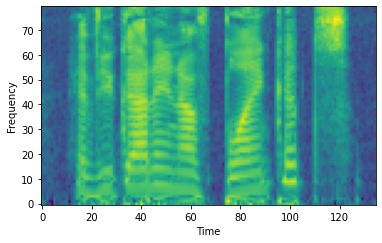

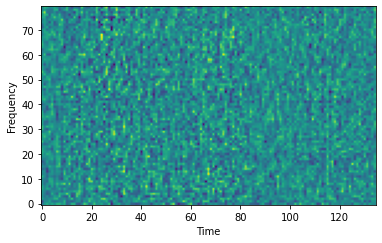

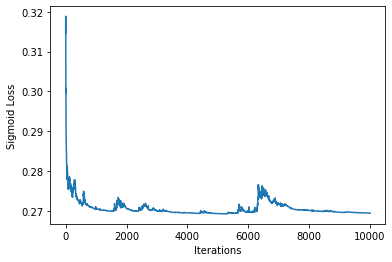

In [5]:
spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features
optimizer = torch.optim.Adam([spect], lr=10)
get_opt_input = GetGradient(model, optimizer)

get_opt_input.get_opt_input(spect, betas, layers[layer], iterations=10000)

# modified = dream(spect, model, "encoder.conv.conv_layers.0", iterations=10, lr=10)
with torch.no_grad():
    # modified.squeeze_(0)``
    spect.squeeze_(0)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features.squeeze_(0).detach().numpy().T)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Frequency")
# plt.show()
plt.figure()
plt.imshow(spect.detach().numpy().T)
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.plot(get_opt_input.loss_list)
plt.xlabel("Iterations")
plt.ylabel("Sigmoid Loss")
plt.show()

In [18]:
spect_grad_data = spect.grad.data[0].numpy()

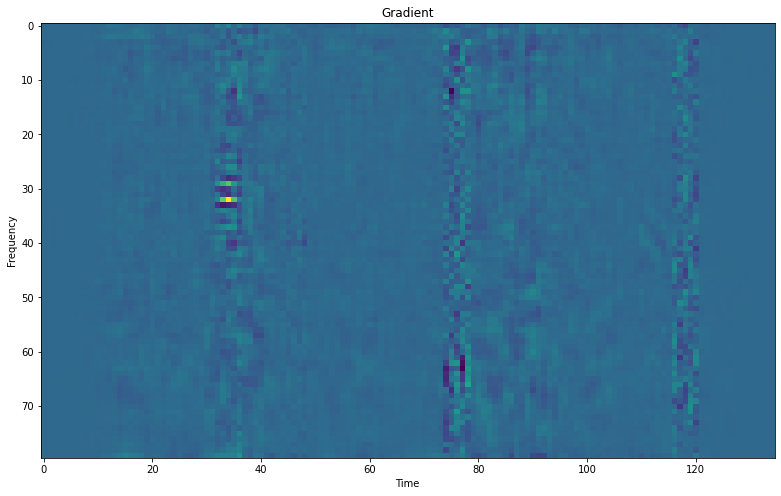

In [23]:
plt.figure(figsize=(15,8))
plt.imshow(spect_grad_data.T)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Gradient")
plt.show()

In [7]:
s = np.abs(spect.detach().numpy())
s.shape

(135, 80)

scipy (97, 129)
hf (80, 135)
ls (43, 189)
ls (43, 189)


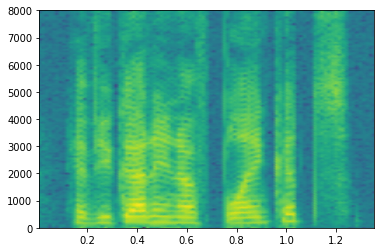

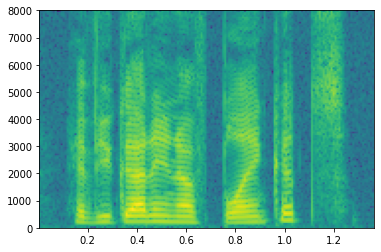

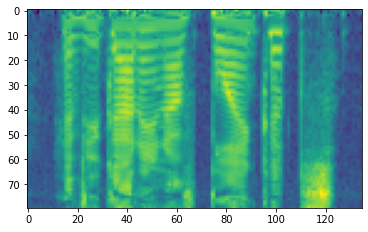

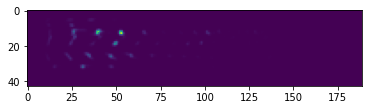

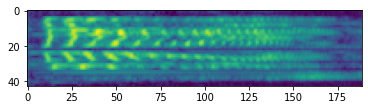

In [8]:
import librosa
import scipy as sp

f, t, sci_spect =sp.signal.spectrogram(aud, fs=16000)
print("scipy",sci_spect.T.shape)
hf_spect = feature_extractor(aud, sampling_rate=16000, return_tensors="pt").input_features.squeeze_(0).detach().numpy().T
print("hf",hf_spect.shape)
librosa_spect = librosa.feature.melspectrogram(aud, sr=16000, n_mels=189)
print("ls",librosa_spect.T.shape)

librosa_spect_dB = librosa.power_to_db(librosa_spect, ref=np.max) 
print("ls",librosa_spect_dB.T.shape)

plt.pcolormesh(t, f, 10*np.log10(sci_spect), shading='gouraud')
plt.figure()
plt.specgram(aud, Fs=16000)
plt.figure()
plt.imshow(hf_spect)
plt.figure()
plt.imshow(librosa_spect.T)
plt.figure()
plt.imshow(librosa_spect_dB.T)
# audio_from_loss_prop = librosa.griffinlim(s)
# audio_from_loss_prop.shape

Text(0.5, 1.0, 'ISTFT')

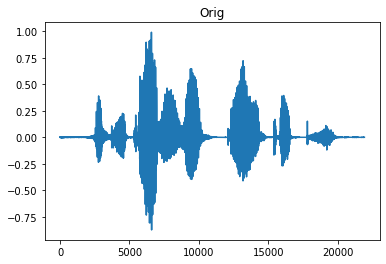

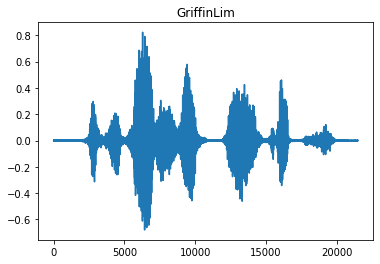

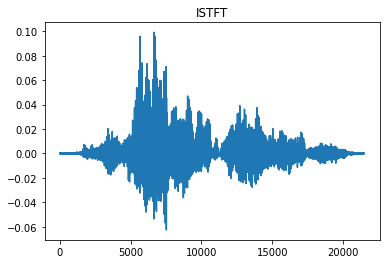

In [9]:
y = aud
S = np.abs(librosa.stft(y))
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S)
# Invert without estimating phase
y_istft = librosa.istft(S)

# fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
# librosa.display.waveshow(y, sr=sr, color='b', ax=ax[0])
plt.plot(y)
plt.title("Orig")
plt.figure()
plt.plot(y_inv)
# plt.plot(audio_from_loss_prop)
# plt.plot(audio_from_loss_prop)
plt.title("GriffinLim")
plt.figure()
plt.plot(y_istft)
plt.title("ISTFT")

In [10]:
from transformers import Speech2TextForConditionalGeneration, Speech2TextProcessor

model_cg = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
processor_cg = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")


In [11]:
aud = neural_data.audio(12)
input_features = processor_cg(aud,padding=True, sampling_rate=16000, return_tensors="pt").input_features

generated_ids = model_cg.generate(inputs=input_features)

transcription = processor_cg.batch_decode(generated_ids)[0]
transcription

'have you got enough blankets'

In [12]:
from auditory_cortex.dataset import Neural_Data
import matplotlib.pyplot as plt

dir = '/depot/jgmakin/data/auditory_cortex/josh_data/data'
# dir = '/Users/akshita/Documents/Research/Makin/data'
subject = '200206'
neural_data = Neural_Data(dir, subject)

win = 40
sent = 12 

edges, psth = neural_data.psth()
# plt.bar(edges,psth, width=(0.8*win/1000))
# plt.xlim(neural_data.duration(sent))
# #plt.xlabel('Time (s)', fontsize=14)
# plt.ylabel('Spike Counts', fontsize=14)

Text(0, 0.5, 'Spike Counts')

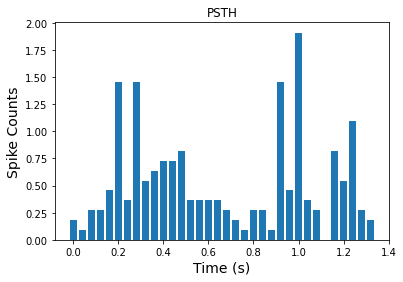

In [13]:
plt.bar(edges,psth, width=(0.8*win/1000))
# plt.xlim(neural_data.duration(sent))
plt.title("PSTH")
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Spike Counts', fontsize=14)